# <a id='toc1_'></a>[Introduction](#toc0_)

This notebook takes gene level summary statistics for body mass index (BMI) in humans and rats, performs network colocalization and defines a cross-species conserved BMI network. The significance of this colocalization is assessed via comparison to an empirical null distribution and analysis of positive and negative control traits.  Analysis of the conserved BMI network can be found in Notebook 2. 

**Figures produced in this notebook:**
* *Figure 2B*. Venn diagram of overlap between input BMI gene sets
* *Figure 2B*. Venn diagram of overlap between rat and human input sets at the network level
* *Supplemental Figure 2A*. Distribution of mean $NPS_{hr}$ scores for colocalization of rat and human BMI
* *Figure 2C*. Scatter plots of $NPS_h$ vs $NPS_r$ defining the conserved BMI network
* *Figure 2D*. Distribution of colocalized network sizes
* *Figure 2E, Supplemental Figure 2E*. Bar plots of network colocalizations for control traits
* *Supplemental Figure 2B*. Venn diagram of overlap between human height seed genes and rat Body Length (BL) without tail
* *Supplemental Figure 2C*. Distribution of mean $NPS_{hr}$ scores for human height and rat Body Length (BL) without tail 
* *Supplemental Figure 2D*. Distribution of colocalized network size for human height and rat Body Length (BL) without tail

**Tables produced in this notebook:**
* *Supplemental Table 1* - NPS scores and Seed gene status

**Note on rerunning the analysis:**
- If `rerun_analysis == False` (default) this notebook will load precomputed values for network propagation. The permutation analyses will still be rerun. Because the permutation analysis involves random shuffling of the data the results generated will differ slightly from those reported.
- If `rerun_analysis == True` this notebook will rerun all network propagation steps, including sampling analysis for human BMI and height. This requires significant memory (32GB+) and takes > 6 hours. Due to randomization in the sampling analysis the results generated will differ slightly from those reported. 


In [1]:
# set whether all analyses should be rerun (see note above)
rerun_analysis = False
if rerun_analysis:
    num_samples=100 # how many sampling runs should be performed (~2min per sample)

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Set Up](#toc2_)    
- [Load Input Data](#toc3_)    
  - [Load molecular interaction network](#toc3_1_)    
  - [Load human and rat BMI seed genes](#toc3_2_)    
- [Gene level overlap](#toc4_)    
    - [Figure 2B (left)](#toc4_1_1_)    
- [Perform BMI network colocalization](#toc5_)    
  - [Calculate Z-scores](#toc5_1_)    
    - [Human BMI](#toc5_1_1_)    
    - [Rat BMI](#toc5_1_2_)    
  - [Permutation Analysis of Mean NPS Score](#toc5_2_)    
    - [Supplemental Figure 2A](#toc5_2_1_)    
  - [Visualize results for BMI network colocalization](#toc5_3_)    
    - [Figure 2C](#toc5_3_1_)    
    - [Figure 2B (right)](#toc5_3_2_)    
  - [Permutation Analysis of Conserved Network size](#toc5_4_)    
    - [Figure 2D](#toc5_4_1_)    
- [Analysis with Rat String Network](#toc6_)    
  - [Load control network](#toc6_1_)    
  - [Perform network colocalization of BMI on control network](#toc6_2_)    
    - [Map human BMI seed genes to the rat network](#toc6_2_1_)    
    - [Map rat BMI genes to rat network](#toc6_2_2_)    
    - [Human Z-scores](#toc6_2_3_)    
    - [Rat Z-scores](#toc6_2_4_)    
    - [Permutation analysis](#toc6_2_5_)    
- [Control analysis](#toc7_)    
  - [Load control trait seed genes](#toc7_1_)    
    - [Positive Control Height/BL](#toc7_1_1_)    
      - [Supplemental Figure 2B](#toc7_1_1_1_)    
    - [Negative Controls](#toc7_1_2_)    
  - [Perform network colocalization of controls](#toc7_2_)    
    - [Z-scores](#toc7_2_1_)    
    - [Permutation analysis](#toc7_2_2_)    
      - [Supplemental Figure 2C](#toc7_2_2_1_)    
      - [Supplemental Figure 2D](#toc7_2_2_2_)    
  - [Plot results of control analysis](#toc7_3_)    
    - [Figure 2E](#toc7_3_1_)    
    - [Supplemental Figure 3E](#toc7_3_2_)    
- [Scaled figures](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Set Up](#toc0_)

In [2]:
# Import required libraries
import os
import sys
import ndex2
from getpass import getpass
import pandas as pd
import mygene
mg = mygene.MyGeneInfo()
from netcoloc import netprop_zscore, netprop

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

In [3]:
# Set up directory paths. Defaults to the Data/ and Figures/ folders within the repository.
cwd = os.path.dirname(os.getcwd())
DATADIR = os.path.join(cwd, "Data/")
FIGDIR = os.path.join(cwd, "Figures/rerun_")

In [4]:
# Import functions specific to this study
sys.path.append(cwd)
from updated_netcoloc_functions import *
from analysis_functions import *
from plotting_functions import *

# <a id='toc3_'></a>[Load Input Data](#toc0_)

Seed gene sets are loaded from gene-level GWAS summary statistics.
* Human BMI seed genes are defined as those meeting a Bonferonni corrected p-value of  p < 0.05 following PASCAL SNP-to-Gene mapping, that are present in PCNet
* Rat BMI seed genes are defined as those meeting a relaxed threshold of p < 1E-6 following positional SNP-to-Gene mapping, that have a human ortholog present in PCNet

## <a id='toc3_1_'></a>[Load molecular interaction network](#toc0_)

Note: if you receive a connection error, please try again

In [5]:
pc_nodes, G_PC = load_pcnet()

number of nodes:
18820

number of edges:
2693109


## <a id='toc3_2_'></a>[Load human and rat BMI seed genes](#toc0_)

In [6]:
# load human seed genes from the PASCAL results
seed_bin_human_BMI = load_human_seed_genes(DATADIR+'inputs/GIANT_BMI_pascal.sum.genescores.txt', 
                                              pc_nodes, 'BMI')

Number of BMI seeds: 1958


In [7]:
# load the rat seed genes from gene-level summary statistics with human ortholog mapping
seed_bin_rat_BMI = load_rat_seed_genes(DATADIR + "inputs/rat_BMI_summary_stats_wo_tail.tsv", pc_nodes, th=1e-4)

Number of genes meeting p < 0.0001 : 476
Number of significant genes with human orthologs: 308
Final number of seed genes in network: 295


In [8]:
# Initialize dictionary for storing the seed genes
seed_dict = {'hBMI': seed_bin_human_BMI, 'rBMI': seed_bin_rat_BMI}

# <a id='toc4_'></a>[Gene level overlap](#toc0_)

In [9]:
def direct_overlap(all_nodes, seeds1, seeds2, labels=["Human", "Rat"], trait=""):
    """Performs a hypergeometric test and generates a venn diagram for the overlap between gene sets
    Args:
        all_nodes (set, list): The background set of network genes containing seeds1 and seeds2
        seeds1 (list): First set of gene indentifiers
        seeds2 (list): Second set of gene indentifiers
        labels (list, optional): Labels for the two gene sets for annotation. Defaults to ["Human", "Rat"].
        trait (str, optional): Name of the trait for annotation. Defaults to "".
    """
    hyper = hypergeom(M=len(all_nodes), n=len(seeds1), N=len(seeds2))
    intersect = set(seeds1).intersection(set(seeds2))
    p_intersect = hyper.sf(len(intersect))
    venn2([len(seeds1)-len(intersect), len(seeds2)-len(intersect), len(intersect)], labels,
        set_colors=('skyblue', 'purple'), alpha=0.7)
    _ = plt.title("-".join(labels) + " " +trait +" seed gene overlap, p="+str(p_intersect))

### <a id='toc4_1_1_'></a>[Figure 2B (left)](#toc0_)

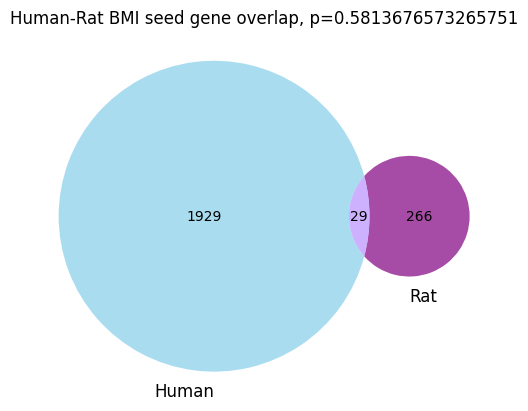

In [10]:
direct_overlap(pc_nodes, seed_bin_human_BMI, seed_bin_rat_BMI, trait="BMI")
plt.savefig(FIGDIR + "2b_BMI_BMI_venn.png", dpi=200, bbox_inches="tight")

# <a id='toc5_'></a>[Perform BMI network colocalization](#toc0_)

In [11]:
# set the number of repitions for determining the null distribution at each node
num_reps = 1000
# precalculate network propagation heats
if rerun_analysis:
    w_prime = netprop.get_normalized_adjacency_matrix(G_PC, conserve_heat=True, weighted=False)
    indiv_heats = netprop.get_individual_heats_matrix(w_prime, alpha=0.5)

## <a id='toc5_1_'></a>[Calculate Z-scores](#toc0_)

In [12]:
# Initialize dictionary for storing z-scores
z_dict = {}

### <a id='toc5_1_1_'></a>[Human BMI](#toc0_)

In [13]:
if rerun_analysis: # perform sampling analysis for network propagation
    BMI_pascal_results = pd.read_csv(DATADIR+"inputs/GIANT_BMI_pascal.sum.genescores.txt", sep="\t")
    BMI_samples = calculate_heat_zscores_with_sampling(BMI_pascal_results, pc_nodes, indiv_heats, G_PC, trait="BMI",
                                                            out_path=DATADIR+"outputs/rerun_", num_samples=num_samples)
    z_human_bin_BMI = get_consensus_z_scores(BMI_samples, 0.75)
else:  # use pre-calculated results
    z_human_bin_BMI = get_consensus_z_scores(DATADIR+'outputs/z_human_bin_BMI_SAMPLED_500_100_weighted.tsv')
z_dict['hBMI'] = z_human_bin_BMI

### <a id='toc5_1_2_'></a>[Rat BMI](#toc0_)

In [14]:
if rerun_analysis: # perform network propagation
    z_rat_BMI = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_rat_BMI,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_rat_BMI[0], columns=["z"]).to_csv(DATADIR+"outputs/rerun_z_rat_BMI.tsv", sep="\t", index=True)
    z_dict['rBMI'] = pd.DataFrame(z_rat_BMI[0], columns=["z"])
else: # use precomputed values
    z_rat_BMI=pd.read_csv(DATADIR+'outputs/z_rat_BMI_relaxed_'+str(num_reps)+'_reps.tsv',sep='\t',
                        index_col='gene',names=['gene','z'], header=0)
    z_dict['rBMI'] = z_rat_BMI

#### STable 1 - All NPS Scores

In [15]:
# export a dataframe of NPS scores
if rerun_analysis:
    nps_df = z_dict['rBMI'].join(z_dict['hBMI'], lsuffix="_rat", rsuffix="_human")
    nps_df.columns = ["NPS_r", "NPS_h"]
    nps_df = nps_df.assign(NPS_hr=nps_df.NPS_r * nps_df.NPS_h)
    nps_df.sort_index().to_csv(DATADIR + "outputs/rerun_rat_human_BMI_all_NPS.tsv", sep="\t")

## <a id='toc5_2_'></a>[Permutation Analysis of Mean NPS Score](#toc0_)

In [16]:
# Generate a null distribution of mean NPS by shuffling the z_scores. Note, due to randomization this distribution will not be exactly the same as the reported result
observed_BMI, permuted_BMI = calculate_mean_z_score_distribution(z_dict['rBMI'], z_dict['hBMI'], num_reps=10000,
                                                       zero_double_negatives=False, overlap_control="bin",
                                                       seed1=seed_dict['rBMI'], seed2=seed_dict['hBMI'])

Overlap seed genes: 29


100%|██████████| 10000/10000 [01:03<00:00, 157.07it/s]


### <a id='toc5_2_1_'></a>[Supplemental Figure 2A](#toc0_)

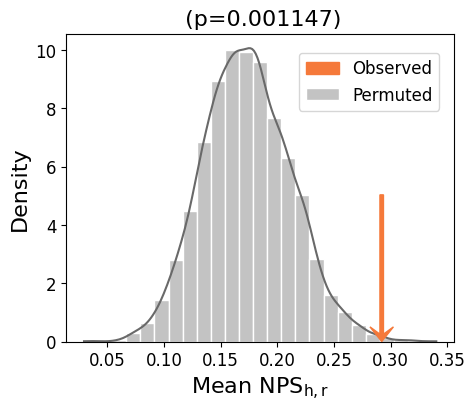

In [17]:
plot_permutation_histogram(permuted_BMI, observed_BMI,'', 'Mean $NPS_{h,r}$',color="dimgrey", arrow_color="#F5793A")
plt.savefig(FIGDIR + "Sup2a_ratBMI_humanBMI_mean_NPS_histogram_400dpi.png",dpi=400, bbox_inches="tight")

## <a id='toc5_3_'></a>[Visualize results for BMI network colocalization](#toc0_)

In [18]:
# compile z scores and seed gene status for each gene in the network
netcoloc_data = pd.DataFrame(z_dict['hBMI']).join(z_dict['rBMI'], lsuffix="_human", rsuffix="_rat")
# Assign seed gene status
netcoloc_data["human_seed"] = netcoloc_data.index.isin(seed_bin_human_BMI) * 1 
netcoloc_data["rat_seed"] = netcoloc_data.index.isin(seed_bin_rat_BMI) * 1 
netcoloc_data["hue"] = netcoloc_data.apply(lambda x: "#F5793A" if (x.z_human > 1) and (x.z_rat > 1) 
                                           and (x.z_human * x.z_rat > 3) else "grey", axis=1)
# get dataset of non-seed genes only
data_non_seed = netcoloc_data.loc[((netcoloc_data.rat_seed ==0) & (netcoloc_data.human_seed==0))]

### <a id='toc5_3_1_'></a>[Figure 2C](#toc0_)

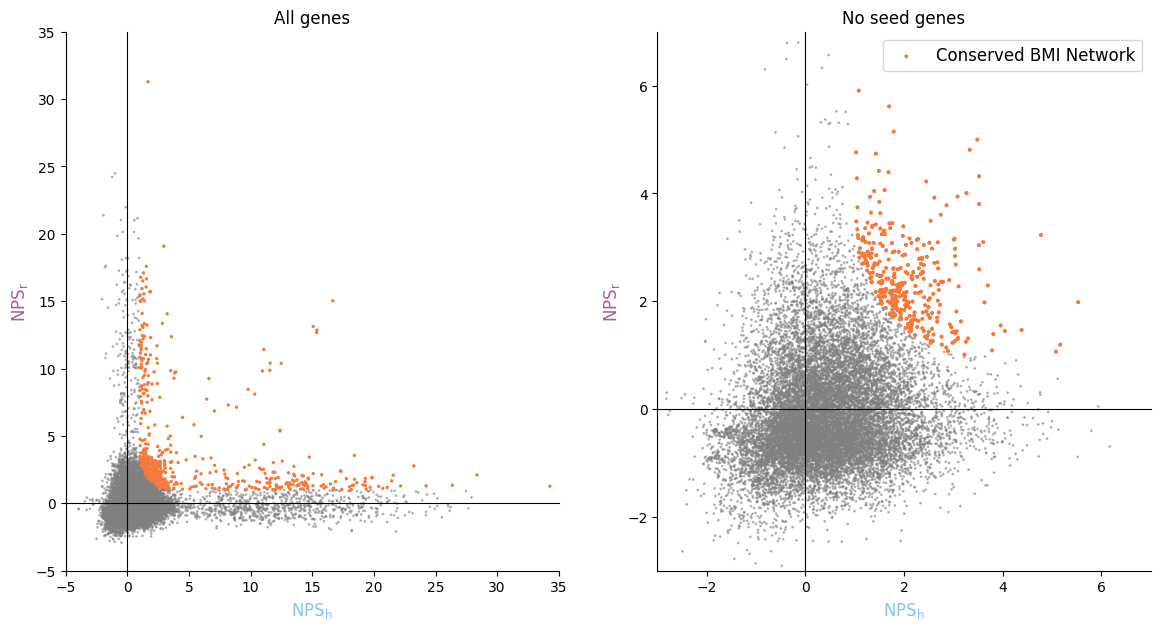

In [19]:
## scatter plot of species NPS scores 
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(14,7))
ax1.scatter(data=netcoloc_data, x="z_human", y="z_rat", color="hue", 
                s=[1 if netcoloc_data.hue[i]=="grey" else 2 for i in range(len(netcoloc_data))], 
                alpha=[0.5 if netcoloc_data.hue[i]=="grey" else 1 for i in range(len(netcoloc_data))], 
                zorder=0, label=None)
# set figure attributes
ax1.spines['left'].set(position=('data', -5), zorder=2)
ax1.spines['bottom'].set(position=('data', -5), zorder=2)
ax1.set_xlabel("$NPS_h$", zorder=4, fontsize=12, color="#85c0F9")
ax1.set_ylabel("$NPS_r$", fontsize=12, color="#A95AA1")
ax1.spines['top'].set_position(('data', 0.0))
ax1.spines['right'].set_position(('data', 0.0))
ax1.set_xlim((-5, 35))
ax1.set_ylim((-5, 35))
_ =ax1.set_title("All genes")

# scatter plot only showing non-seed genes
ax2.scatter(data=data_non_seed, x="z_human", y="z_rat", color="hue", 
                s=[1 if data_non_seed.hue[i]=="grey" else 3 for i in range(len(data_non_seed))], 
                alpha=[0.5 if data_non_seed.hue[i]=="grey" else 1 for i in range(len(data_non_seed))], 
                zorder=0, label=None)
ax2.scatter(data = data_non_seed[data_non_seed.hue != "grey"], x="z_human", y="z_rat", color="hue", s=3, alpha=1, 
                zorder=1, label= "Conserved BMI Network" )
ax2.set_ylabel("$NPS_r$", fontsize=12, color="#A95AA1")
ax2.set_xlim((-3, 7))
ax2.set_ylim((-3, 7))
ax2.spines['left'].set(position=('data', -3), zorder=2)
ax2.spines['bottom'].set(position=('data', -3), zorder=2)
ax2.set_xlabel("$NPS_h$", zorder=4, fontsize=12, color="#85c0F9")
ax2.spines['top'].set_position(('data', 0.0))
ax2.spines['right'].set_position(('data', 0.0))
_ =ax2.set_title("No seed genes")
plt.legend(fontsize=12)

plt.savefig(FIGDIR + "2c_BMI_NPS_scatter_plots_conserved_network.png", bbox_inches="tight", dpi=400)

In [20]:
## Get gene sets meeting each of the thresholds
h_set = set(netcoloc_data[netcoloc_data.z_human > 1].index)
r_set = set(netcoloc_data[netcoloc_data.z_rat > 1].index)
b_set = set(netcoloc_data[netcoloc_data.hue != "grey"].index)

### <a id='toc5_3_2_'></a>[Figure 2B (right)](#toc0_)

/cellar/users/snwright/anaconda3/envs/rat_test/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


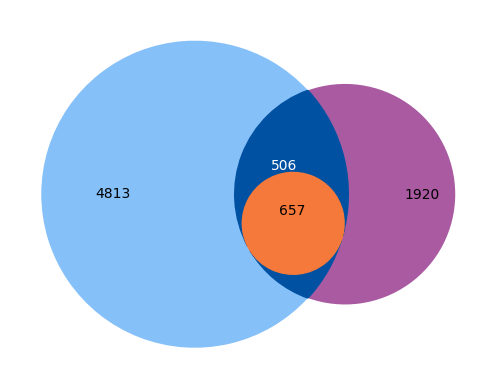

In [21]:
# create new venn diagram
c = venn3([h_set, r_set, b_set.intersection(h_set).intersection(r_set)], 
            set_colors = ["#85c0f9", "#a95aa1", "#f5793a"], alpha=1, set_labels=["", "", ""])
c.get_patch_by_id('111').set_color('#f5793a')
c.get_patch_by_id('110').set_color('#0051a2')
c.get_label_by_id('110').set_color('white')
plt.savefig(FIGDIR + "2b_BMI_BMI_colocalized_venn.png", dpi=400, bbox_inches="tight")

In [22]:
# Get statistics of gene sources within the conserved network
conserved_network = netcoloc_data[netcoloc_data["hue"]!="grey"]
print("Distribution of conserved network genes:")
print("Human & Rat Seeds:", len(conserved_network[((conserved_network.human_seed==1) & (conserved_network.rat_seed==1))]))
print("Human Only Seeds:", len(conserved_network[((conserved_network.human_seed==1) & (conserved_network.rat_seed==0))]))
print("Rat Only Seeds:", len(conserved_network[((conserved_network.human_seed==0) & (conserved_network.rat_seed==1))]))
print("Network Genes:", len(conserved_network[((conserved_network.human_seed==0) & (conserved_network.rat_seed==0))]))

Distribution of conserved network genes:
Human & Rat Seeds: 21
Human Only Seeds: 207
Rat Only Seeds: 93
Network Genes: 336


## <a id='toc5_4_'></a>[Permutation Analysis of Conserved Network size](#toc0_)

In [23]:
# Generate a null distribution of colocalized network size by shuffling the z_scores and applying the thresholds:
# NPS_r > 1, NPS_h > 1, NPS_hr > 3
observed_BMI_sz, permuted_BMI_sz = calculate_expected_overlap(z_dict['rBMI'], z_dict['hBMI'], 
                                                            z_score_threshold=3, z1_threshold=1.0,
                                                            z2_threshold=1.0, num_reps=10000, plot=False, 
                                                            overlap_control="bin",
                                                            seed1=seed_dict['rBMI'], seed2=seed_dict['hBMI'])

Overlap seed genes: 29


100%|██████████| 10000/10000 [02:23<00:00, 69.83it/s]


### <a id='toc5_4_1_'></a>[Figure 2D](#toc0_)

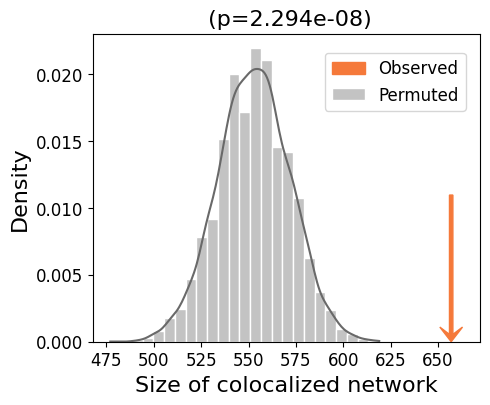

In [24]:
plot_permutation_histogram(permuted_BMI_sz, observed_BMI_sz,'', 'Size of colocalized network', color="dimgrey",
                          arrow_color="#F5793A")
plt.savefig(FIGDIR + "2d_ratBMI_humanBMI_netcoloc_size_histogram_400dpi.png",dpi=400, bbox_inches="tight")

# <a id='toc6_'></a>[Analysis with Rat String Network](#toc0_)

## <a id='toc6_1_'></a>[Load control network](#toc0_)

To test whether the results are reproducible on a rat network we defined a high confidence rat network from STRING v11.5. From all links available for *R. norvegicus* we extracted all links with a combined score > 700 (equivalent to score > 0.7).

In [25]:
interactome_uuid='880c7d8c-f5ad-11ec-ac45-0ac135e8bacf' # for Rat String High Confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_rat_HC = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes_rat_HC = list(G_rat_HC.nodes)

# remove any self edges
G_rat_HC.remove_edges_from(nx.selfloop_edges(G_rat_HC))

# remove unconnected nodes
remove_nodes = [n[0] for n in G_rat_HC.degree() if n[1]==0]
G_rat_HC.remove_nodes_from(remove_nodes)

# print out interactome num nodes and edges for diagnostic purposes
print('Number of nodes:')
print(len(G_rat_HC.nodes))
print('\nNumber of edges:')
print(len(G_rat_HC.edges))


Number of nodes:
16787

Number of edges:
277852


## <a id='toc6_2_'></a>[Perform network colocalization of BMI on control network](#toc0_)

In [26]:
# precalculate heats
if rerun_analysis:
    w_prime_rat_HC = netprop.get_normalized_adjacency_matrix(G_rat_HC, conserve_heat=True, weighted=False)
    indiv_heats_rat_HC = netprop.get_individual_heats_matrix(w_prime_rat_HC, alpha=0.5)

### <a id='toc6_2_1_'></a>[Map human BMI seed genes to the rat network](#toc0_)

In [27]:
# process ortholog mappings from HCOP
ortho_map = pd.read_csv(DATADIR + "Reference/human_rat_hcop_fifteen_column.txt.gz", sep="\t", index_col=None)
# restrict to entries with symbols for both species
ortho_map = ortho_map[(ortho_map["human_symbol"] != "-")]
ortho_map = ortho_map[(ortho_map["rat_symbol"] != "-")]
# restrict to entries with chromosome information
ortho_map = ortho_map[(ortho_map["human_chr"] != "-")]
ortho_map = ortho_map[(ortho_map["rat_chr"] != "-")]
# quantify number of supporting sources
ortho_map["N_sources"] = ortho_map.support.apply(lambda x: len(x.split(",")))
ortho_map = ortho_map.sort_values(by=["human_symbol", "N_sources"])

In [28]:
# Retrieve all significant genes without filtering through PCNet
alpha_corrected_human=2.5e-6
all_human_BMI_seed_genes = pd.read_csv(DATADIR+"inputs/GIANT_BMI_pascal.sum.genescores.txt", sep="\t")
all_human_BMI_seed_genes = all_human_BMI_seed_genes.loc[all_human_BMI_seed_genes.pvalue < alpha_corrected_human].gene_symbol.unique()

In [29]:
# map human BMI to rat orthologs
ortho_map_bmi = ortho_map[ortho_map.human_symbol.isin(all_human_BMI_seed_genes)]
# take ortholog supported by largest number of databases
seed_human_bmi_rat_orthos = ortho_map_bmi.drop_duplicates(subset="human_symbol", 
                                                          keep="last", ignore_index=True).loc[:, ("human_symbol", "rat_symbol")]
print("Number of significant human BMI genes:", len(seed_human_bmi_rat_orthos))

Number of significant human BMI genes: 1935


In [30]:
# take ortholog supported by largest number of databases
seed_human_bmi_rat_orthos = ortho_map_bmi.drop_duplicates(subset="human_symbol", 
                                                          keep="last", ignore_index=True).loc[:, ("human_symbol", "rat_symbol")]
human_bmi_seed_genes_rat_HC = seed_human_bmi_rat_orthos.rat_symbol.unique()
human_bmi_seed_genes_rat_HC = [g for g in human_bmi_seed_genes_rat_HC if g in G_rat_HC.nodes]
print("Rat orthologs of human BMI genes in rat STRING:", len(human_bmi_seed_genes_rat_HC))

Rat orthologs of human BMI genes in rat STRING: 1598


In [31]:
seed_dict["hBMI_RS"] = human_bmi_seed_genes_rat_HC

### <a id='toc6_2_2_'></a>[Map rat BMI genes to rat network](#toc0_)

In [32]:
rat_bmi_results = pd.read_csv(DATADIR + "inputs/rat_BMI_summary_stats_wo_tail.tsv", sep="\t")
rat_bmi_seed_genes_rat_HC = rat_bmi_results.loc[rat_bmi_results["TopSNP P-Value"] <= 1e-4, ("Gene")].values
print("Total significant rat BMI genes:", len(rat_bmi_seed_genes_rat_HC))

Total significant rat BMI genes: 476


In [33]:
# take rat seed genes directly from the results
rat_bmi_seed_genes_rat_HC = [g for g in rat_bmi_seed_genes_rat_HC if g in G_rat_HC.nodes]
print("Rat BMI genes in rat STRING network:", len(rat_bmi_seed_genes_rat_HC))

Rat BMI genes in rat STRING network: 267


In [34]:
seed_dict["rBMI_RS"] = rat_bmi_seed_genes_rat_HC

### <a id='toc6_2_3_'></a>[Human Z-scores](#toc0_)

In [35]:
if rerun_analysis:
    # map pascal results to rat genes
    BMI_pascal_results = pd.read_csv(DATADIR+"inputs/GIANT_BMI_pascal.sum.genescores.txt", sep="\t")
    mapped_pascal_results = BMI_pascal_results.merge(seed_human_bmi_rat_orthos, left_on="gene_symbol", right_on="human_symbol")
    mapped_pascal_results = mapped_pascal_results.drop(columns = "gene_symbol")
    mapped_pascal_results = mapped_pascal_results.rename(columns = {"rat_symbol":"gene_symbol"})
    # run the sampling network propagation
    BMI_samples_rat_HC = calculate_heat_zscores_with_sampling(mapped_pascal_results, nodes_rat_HC, 
                                                                indiv_heats_rat_HC, G_rat_HC, trait="BMI",
                                                                out_path=DATADIR+"outputs/controls/rerun_rat_string_human_",
                                                                num_samples=num_samples)
    z_human_bin_BMI_rat_HC = get_consensus_z_scores(BMI_samples_rat_HC, 0.75)
else: # use precomputed results
    z_human_bin_BMI_rat_HC = get_consensus_z_scores(DATADIR+"outputs/controls/rat_string_human_giant_BMIsampling_500_100.tsv", 0.75)
    
z_dict["hBMI_RS"] = z_human_bin_BMI_rat_HC

### <a id='toc6_2_4_'></a>[Rat Z-scores](#toc0_)

In [36]:
if rerun_analysis: # perform network propagation
    z_rat_bmi_rat_net = netprop_zscore.calculate_heat_zscores(indiv_heats_rat_HC, list(G_rat_HC.nodes),
                                                    dict(G_rat_HC.degree), 
                                                    rat_bmi_seed_genes_rat_HC,
                                                    num_reps=num_reps,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    z_rat_bmi_rat_net = pd.DataFrame(z_rat_bmi_rat_net[0], columns=['z'])
    z_rat_bmi_rat_net.to_csv(DATADIR + "outputs/controls/rerun_rat_string_rat_BMI_zscores.tsv", sep="\t", header=False)
else: # use precomputed results
    z_rat_bmi_rat_net = pd.read_csv(DATADIR + "outputs/controls/rat_string_rat_BMI_zscores.tsv", header=None, sep="\t", index_col=0, names=["z"])
z_dict["rBMI_RS"] = z_rat_bmi_rat_net

### <a id='toc6_2_5_'></a>[Permutation analysis](#toc0_)

Overlap seed genes: 27


100%|██████████| 1000/1000 [00:13<00:00, 74.43it/s]


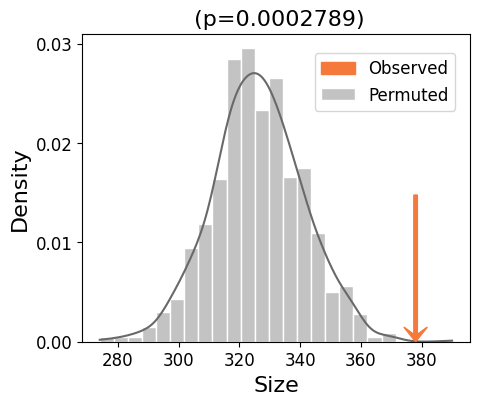

In [37]:
seeds_rat = [n for n in rat_bmi_seed_genes_rat_HC if n in nodes_rat_HC]
seeds_human = [n for n in human_bmi_seed_genes_rat_HC if n in nodes_rat_HC]

# Generate a null distibution of conserved network sizes
observed_rat_HC, permuted_rat_HC = calculate_expected_overlap(z_rat_bmi_rat_net.fillna(0), 
                                                        z_human_bin_BMI_rat_HC.fillna(0), num_reps=1000,
                                                        overlap_control="bin",
                                                       seed1=seeds_rat, seed2=seeds_human)
plot_permutation_histogram(permuted_rat_HC, observed_rat_HC,'', 'Size', color="dimgrey", arrow_color="#F5793A")

# <a id='toc7_'></a>[Control analysis](#toc0_)

## <a id='toc7_1_'></a>[Load control trait seed genes](#toc0_)

### <a id='toc7_1_1_'></a>[Positive Control Height/BL](#toc0_)

In [38]:
seed_bin_human_height = load_human_seed_genes(DATADIR+'inputs/GIANT_standing_height_pascal.sum.genescores.txt', 
                                              pc_nodes, 'height')

Number of height seeds: 6140


In [39]:
seed_bin_rat_BL=load_rat_seed_genes(DATADIR + "inputs/rat_BL_summary_stats_wo_tail.tsv", pc_nodes, th=1e-4)

Number of genes meeting p < 0.0001 : 538
Number of significant genes with human orthologs: 360
Final number of seed genes in network: 337


#### <a id='toc7_1_1_1_'></a>[Supplemental Figure 2B](#toc0_)

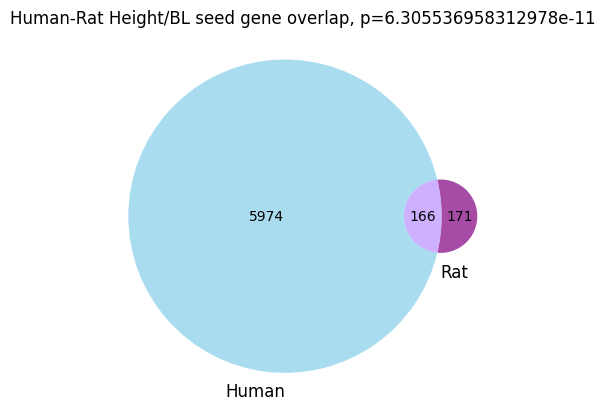

In [40]:
direct_overlap(pc_nodes, seed_bin_human_height, seed_bin_rat_BL, trait="Height/BL")
plt.savefig(FIGDIR + "Sup2b_height_BL_venn.png")

In [41]:
# Also load the set of rat BL genes that are present in the rat STRING network
rat_bl_results = pd.read_csv(DATADIR + "inputs/rat_BL_summary_stats_wo_tail.tsv", sep="\t")
rat_bl_seed_genes_rat_HC = rat_bl_results.loc[rat_bl_results["TopSNP P-Value"] < 1e-4, ("Gene")].values
rat_bl_seed_genes_rat_HC = [g for g in rat_bl_seed_genes_rat_HC if g in G_rat_HC.nodes]
seed_dict["rBL_RS"] = rat_bl_seed_genes_rat_HC
print("Rat BL genes in rat STRING network:", len(rat_bl_seed_genes_rat_HC))

Rat BL genes in rat STRING network: 306


### <a id='toc7_1_2_'></a>[Negative Controls](#toc0_)

In [42]:
# Human control trait seed genes
seed_bin_human_AR = pd.read_csv(DATADIR+'inputs/controls/humanAR_seed_PASCAL'+'_bonf.txt',
                               sep="\t", header=None)[0].tolist() # allergic rhinitis symptoms
seed_bin_human_FEV1 = pd.read_csv(DATADIR+'inputs/controls/humanFEV1_seed_PASCAL'+'_bonf.txt',
                               sep="\t", header=None)[0].tolist() # Forced expiratory volume per second
seed_bin_human_SMOK = pd.read_csv(DATADIR+'inputs/controls/humanSMOK_seed_PASCAL'+'_bonf.txt',
                               sep="\t", header=None)[0].tolist() # never smoked cigarettes
seed_bin_human_Neo = pd.read_csv(DATADIR+'inputs/controls/humanNeo_seed_PASCAL'+'_bonf.txt',
                               sep="\t", header=None)[0].tolist() # non-cancer neoplasms

print("Number of AR seeds:", len(seed_bin_human_AR))
print("Number of FEV1 seeds:", len(seed_bin_human_FEV1))
print("Number of SMOK seeds:", len(seed_bin_human_SMOK))
print("Number of Neo seeds:", len(seed_bin_human_Neo))

Number of AR seeds: 535
Number of FEV1 seeds: 1285
Number of SMOK seeds: 209
Number of Neo seeds: 166


## <a id='toc7_2_'></a>[Perform network colocalization of controls](#toc0_)

### <a id='toc7_2_1_'></a>[Z-scores](#toc0_)

In [43]:
# positive control - Human Height vs rat Body Length on PCNet
if rerun_analysis:
    # human sampling analysis for network propagation
    height_pascal_results = pd.read_csv(DATADIR+"inputs/GIANT_standing_height_pascal.sum.genescores.txt", sep="\t")
    height_samples = calculate_heat_zscores_with_sampling(height_pascal_results, pc_nodes, indiv_heats, G_PC, trait="height",
                                                            out_path=DATADIR+"outputs/controls/rerun_", num_samples=num_samples)
    z_human_bin_height = get_consensus_z_scores(height_samples, 0.75)
    z_dict['hHeight'] = z_human_bin_height
    # rat network propagation
    z_rat_BL = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_rat_BL,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_rat_BL[0], columns=["z"]).to_csv(DATADIR+"outputs/controls/rerun_z_rat_BL.tsv", sep="\t", index=True)
    z_dict['rBL'] = pd.DataFrame(z_rat_BL[0], columns=["z"])
else:
    # human precomputed scores
    z_human_bin_height = get_consensus_z_scores(DATADIR+'outputs/controls/z_human_bin_Height_SAMPLED_500_100_weighted.tsv')
    z_dict['hHeight'] = z_human_bin_height
    # rat precomputed scores
    out_name = 'rat_BL_relaxed'
    z_rat_BL=pd.read_csv(DATADIR + 'outputs/controls/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                         index_col='gene', names=['gene', 'z'], header=0)
    z_dict['rBL'] = z_rat_BL

In [44]:
if rerun_analysis: # perform network propagation
    z_rat_BL_rat_net = netprop_zscore.calculate_heat_zscores(indiv_heats_rat_HC, list(G_rat_HC.nodes),
                                                    dict(G_rat_HC.degree), 
                                                    rat_bl_seed_genes_rat_HC,
                                                    num_reps=num_reps,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    z_rat_BL_rat_net = pd.DataFrame(z_rat_BL_rat_net[0], columns=['z'])
    z_rat_BL_rat_net.to_csv(DATADIR + "outputs/controls/rerun_rat_string_rat_BL_zscores.tsv", sep="\t", header=False)
else: # use precomputed results
    z_rat_BL_rat_net = pd.read_csv(DATADIR + "outputs/controls/rat_string_rat_BL_zscores.tsv", header=None, sep="\t", index_col=0, names=["z"])

z_dict['rBL_RS'] = z_rat_BL_rat_net

In [45]:
# negative controls. Both AR and FEV1 have > 500 seed genes so were run with sampling, which is not repeated here. 
if rerun_analysis:
    # Allergic Rhinitis (AR)
    z_human_bin_AR = get_consensus_z_scores(DATADIR+"outputs/controls/z_human_AR_sampling_500_100.tsv", 0.75)
    z_dict['hAR'] = z_human_bin_AR
    # Forced expiratory volume (FEV1)
    z_human_bin_FEV1 = get_consensus_z_scores(DATADIR+"outputs/controls/z_human_FEV1_sampling_500_100.tsv")
    z_dict['hFEV1'] = z_human_bin_FEV1
    # Never smoked cigarettes (SMOK)
    z_human_bin_SMOK = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_human_SMOK,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_human_bin_SMOK[0], columns=["z"]).to_csv(DATADIR+"outputs/controls/rerun_z_human_SMOK.tsv", sep="\t", index=True)
    z_dict['hSMOK'] = pd.DataFrame(z_human_bin_SMOK[0], columns=["z"])
    # Non-cancer neoplasms (Neo)
    z_human_bin_Neo = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_human_Neo,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_human_bin_Neo[0], columns=["z"]).to_csv(DATADIR+"outputs/controls/rerun_z_human_Neo.tsv", sep="\t", index=True)
    z_dict['hNeo'] = pd.DataFrame(z_human_bin_Neo[0], columns=["z"])
else: # use precomputed scores
    # Allergic Rhinitis (AR)
    z_human_bin_AR=get_consensus_z_scores(DATADIR+"outputs/controls/z_human_AR_sampling_500_100.tsv", 0.75)
    z_dict['hAR'] = z_human_bin_AR
    # Forced expiratory volume (FEV1)
    z_human_bin_FEV1=get_consensus_z_scores(DATADIR+"outputs/controls/z_human_FEV1_sampling_500_100.tsv")
    z_dict['hFEV1'] = z_human_bin_FEV1
    # Never smoked cigarettes (SMOK)
    out_name = 'human_SMOK_PASCAL'+'_bonf'
    z_human_bin_SMOK=pd.read_csv(DATADIR+'outputs/controls/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                            index_col='gene',names=['gene','z'], header=0)
    z_dict['hSMOK'] = z_human_bin_SMOK
    # Non-cancer neoplasms (Neo)
    out_name = 'human_Neo_PASCAL'+'_bonf'
    z_human_bin_Neo=pd.read_csv(DATADIR+'outputs/controls/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                            index_col='gene',names=['gene','z'], header=0)
    z_dict['hNeo'] = z_human_bin_Neo

In [46]:
# add control seed genes to the seed gene dictionary
seed_dict = {'hHeight': seed_bin_human_height,
    'rBMI':seed_bin_rat_BMI,'rBL':seed_bin_rat_BL,
             'hAR':seed_bin_human_AR,'hFEV1':seed_bin_human_FEV1,
             'hSMOK':seed_bin_human_SMOK, 'hNeo':seed_bin_human_Neo, **seed_dict}

### <a id='toc7_2_2_'></a>[Permutation analysis](#toc0_)

In [47]:
# define the comparisons to be made
control_combinations = [('rBMI', 'hBMI'), ('rBMI_RS', 'hBMI_RS'),  
                        ('rBL', 'hHeight'), ('rBMI', 'rBL'),('rBMI_RS', 'rBL_RS'), ('rBMI', 'hHeight'),
                        ('hBMI', 'hHeight'), ('hBMI', 'rBL'),  
                        ('rBMI', 'hAR'), ('rBMI', 'hFEV1'), ('rBMI', 'hNeo'), ('rBMI', 'hSMOK')]

In [48]:
## height/BL
observed_height, permuted_height = calculate_mean_z_score_distribution(z_dict['rBL'], z_dict['hHeight'], num_reps=1000,
                                                       zero_double_negatives=False, overlap_control="bin",
                                                       seed1=seed_dict['rBL'], seed2=seed_dict['hHeight'])

Overlap seed genes: 166


100%|██████████| 1000/1000 [00:06<00:00, 158.76it/s]


#### <a id='toc7_2_2_1_'></a>[Supplemental Figure 2C](#toc0_)

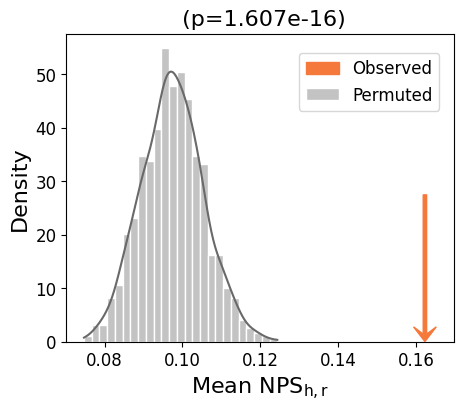

In [49]:
plot_permutation_histogram(permuted_height, observed_height,'', 'Mean $NPS_{h,r}$',color="dimgrey", arrow_color="#F5793A")
plt.savefig(FIGDIR + "Sup2c_ratBL_humanHeight_mean_NPS_histogram_400dpi.png",dpi=400, bbox_inches="tight")

In [50]:
# Generate a null distribution of colocalized network size by shuffling the z_scores and applying the thresholds:
# NPS_r > 1, NPS_h > 1, NPS_hr > 3
observed_height_sz, permuted_height_sz = calculate_expected_overlap(z_dict['rBL'], z_dict['hHeight'], 
                                                            z_score_threshold=3, z1_threshold=1.0,
                                                            z2_threshold=1.0, num_reps=1000, plot=False, 
                                                            overlap_control="bin",
                                                            seed1=seed_dict['rBL'], seed2=seed_dict['hHeight'])

Overlap seed genes: 166


100%|██████████| 1000/1000 [00:14<00:00, 69.49it/s]


#### <a id='toc7_2_2_2_'></a>[Supplemental Figure 2D](#toc0_)

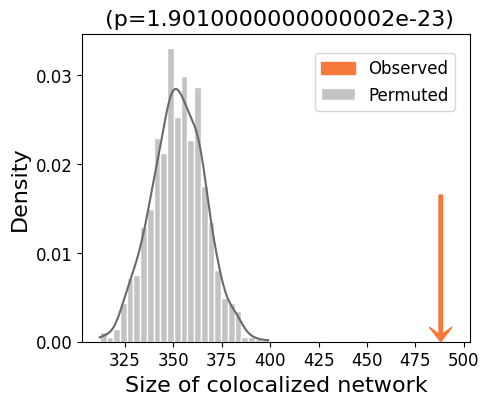

In [51]:
plot_permutation_histogram(permuted_height_sz, observed_height_sz,'', 'Size of colocalized network', color="dimgrey",
                          arrow_color="#F5793A")
plt.savefig(FIGDIR + "Sup2d_ratBL_humanHeight_netcoloc_size_histogram_400dpi.png",dpi=400, bbox_inches="tight")

In [52]:
control_analysis = []
# analyse all combinations
for combo in control_combinations:
    observed, permuted = calculate_expected_overlap(z_dict[combo[0]], z_dict[combo[1]], 
                                                    z_score_threshold=3, z1_threshold=1.0,
                                                    z2_threshold=1.0, num_reps=1000, plot=False, 
                                                    overlap_control="bin",
                                                    seed1=seed_dict[combo[0]], seed2=seed_dict[combo[1]])
    control_analysis.append(get_permutation_stats(observed, permuted, "-".join(combo)))

Overlap seed genes: 29


100%|██████████| 1000/1000 [00:14<00:00, 67.84it/s]


Overlap seed genes: 27


100%|██████████| 1000/1000 [00:12<00:00, 77.73it/s]


Overlap seed genes: 166


100%|██████████| 1000/1000 [00:14<00:00, 69.65it/s]


Overlap seed genes: 25


100%|██████████| 1000/1000 [00:14<00:00, 70.07it/s]


Overlap seed genes: 23


100%|██████████| 1000/1000 [00:13<00:00, 76.18it/s]


Overlap seed genes: 109


100%|██████████| 1000/1000 [00:14<00:00, 69.48it/s]


Overlap seed genes: 1057


100%|██████████| 1000/1000 [00:14<00:00, 69.92it/s]


Overlap seed genes: 57


100%|██████████| 1000/1000 [00:13<00:00, 71.66it/s]


Overlap seed genes: 8


100%|██████████| 1000/1000 [00:14<00:00, 70.94it/s]


Overlap seed genes: 6


100%|██████████| 1000/1000 [00:14<00:00, 71.24it/s]


Overlap seed genes: 0


100%|██████████| 1000/1000 [00:14<00:00, 69.82it/s]


Overlap seed genes: 1


100%|██████████| 1000/1000 [00:14<00:00, 70.00it/s]


In [53]:
control_results = pd.concat(control_analysis)

## <a id='toc7_3_'></a>[Plot results of control analysis](#toc0_)

In [54]:
tick_list = ["-".join(combo) for combo in control_combinations]

def combo_label(combo):
    label = "/".join(combo)
    label = label.replace("r", "Rat ")
    label = label.replace("/h", "/Human ")
    label = label.replace("_RS", " (RS)")
    label = label.replace(" (RS)/", "/")
    label = label.replace("hBMI", "Human BMI")
    return label

label_list = [combo_label(combo) for combo in control_combinations]

### <a id='toc7_3_1_'></a>[Figure 2E](#toc0_)

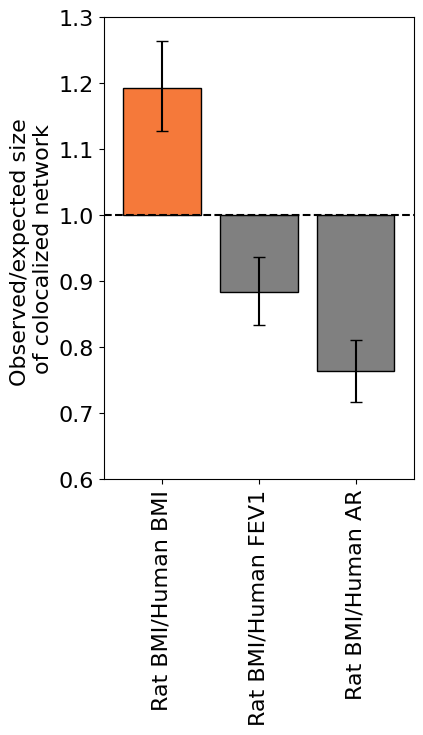

In [55]:
plt.figure(figsize=(4, 6))
main_fig = control_results.loc[['rBMI-hBMI', 'rBMI-hFEV1', 'rBMI-hAR']]
plt.bar(x = main_fig.index,
       bottom= 1, height = main_fig.Mean - 1, capsize=4, edgecolor="black",
        yerr = [main_fig.Mean - main_fig.Lower, main_fig.Upper - main_fig.Mean],
       color = ["#f5793a"]*1 + ["grey"]*2)

plt.xticks(fontsize=16, rotation=90, ticks=main_fig.index, 
          labels = ['Rat BMI/Human BMI', 'Rat BMI/Human FEV1', 'Rat BMI/Human AR'])
plt.ylabel("Observed/expected size \nof colocalized network", fontsize=16)
plt.yticks(fontsize=16)
plt.hlines(y=1, xmin=-0.6, xmax=11.6, linestyle="dashed", color="black")
plt.xlim(-0.6, 2.6)
plt.ylim(0.6, 1.3)
plt.savefig(FIGDIR + "2e_BMI_control_barplot.png", format='png', bbox_inches="tight", dpi=500)

### <a id='toc7_3_2_'></a>[Supplemental Figure 3E](#toc0_)

Orange: BMI/BMI
White: Positive Controls
Grey: Negative Controls


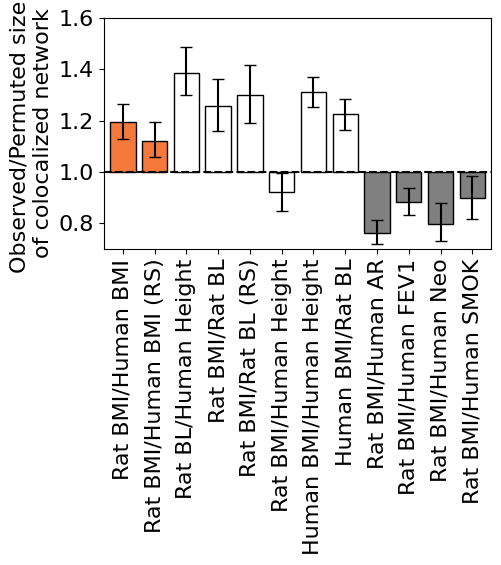

In [56]:
plt.figure(figsize=(5, 3))
plot_results = control_results.loc[tick_list]
plt.bar(x = tick_list,
       bottom= 1, height = plot_results.Mean - 1, capsize=4, edgecolor="black",
        yerr = [plot_results.Mean - plot_results.Lower, plot_results.Upper - plot_results.Mean],
       color = ["#f5793a"]*2 + ["white"]*6 + ["grey"]*4)

plt.xticks(fontsize=16, rotation=90, ticks= tick_list,
          labels =label_list)
plt.yticks(fontsize=16)
plt.hlines(y=1, xmin=-0.6, xmax=11.6, linestyle="dashed", color="black")
plt.ylabel("Observed/Permuted size \nof colocalized network", fontsize=16)
plt.xlim(-0.6, 11.6)
plt.ylim(0.7, 1.6)
plt.savefig(FIGDIR + "Sup2e_control_plot.png", bbox_inches="tight", dpi=400)
print("Orange: BMI/BMI\nWhite: Positive Controls\nGrey: Negative Controls")

In [57]:
control_results

,Mean,Upper,Lower,p
rBMI-hBMI,1.192859,1.263462,1.126930,2.070000e-08
rBMI_RS-hBMI_RS,1.122124,1.194969,1.057514,3.946000e-04
rBL-hHeight,1.385639,1.487805,1.297872,3.146000e-21
rBMI-rBL,1.255661,1.363014,1.160350,1.220000e-07
rBMI_RS-rBL_RS,1.300891,1.416309,1.191336,1.220000e-08
rBMI-hHeight,0.921489,0.996241,0.849359,9.523000e-01
hBMI-hHeight,1.311441,1.369632,1.254213,9.719000e-32
hBMI-rBL,1.224801,1.285959,1.162539,1.060000e-12
rBMI-hAR,0.763710,0.811494,0.717480,1.000000e+00
rBMI-hFEV1,0.883011,0.937132,0.833916,9.996000e-01


# <a id='toc8_'></a>[Scaled figures](#toc0_)

Create to-scale figures for publication. 

In [58]:
def direct_overlap2(all_nodes, seeds1, seeds2, labels=["Human", "Rat"], trait=""):
    fig, ax  = plt.subplots(ncols=1, nrows=1, figsize=(2.5, 3))
    hyper = hypergeom(M=len(all_nodes), n=len(seeds1), N=len(seeds2))
    intersect = set(seeds1).intersection(set(seeds2))
    p_intersect = hyper.sf(len(intersect))
    v = venn2([len(seeds1)-len(intersect), len(seeds2)-len(intersect), len(intersect)], labels,
     set_colors=('skyblue', 'purple'), alpha=0.7, ax=ax)
    v.get_label_by_id('10').set_fontsize(7)
    v.get_label_by_id('11').set_fontsize(7)
    v.get_label_by_id('01').set_fontsize(7)
    v.get_label_by_id('A').set_fontsize(7)
    v.get_label_by_id('B').set_fontsize(7)
    v.get_label_by_id('01').set_color("white")

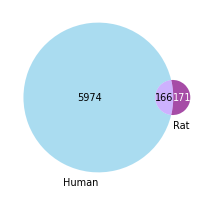

In [59]:
direct_overlap2(pc_nodes, seed_bin_human_height, seed_bin_rat_BL, trait="Height/BL")
plt.savefig(FIGDIR + "scaled_height_venn.png", dpi=500, bbox_inches="tight")

In [60]:
def plot_permutation_histogram2(permuted, observed, title="", xlabel="Observed vs Permuted", color="cornflowerblue", arrow_color="red"):
    """Plot an observed value against a distribution of permuted values

    Args:
        permuted (list): A list of permuted values that form the disribution
        observed (float): The observed value of interest
        title (str): Plot title. Defaults to "".
        xlabel (str): The x axis title. Defaults to "Observed vs Permuted".
        color (str, optional): The color of the histogram. Defaults to "cornflowerblue".
        arrow_color (str, optional): The color of the arrow pointing to observed value. Defaults to "red".
    """
    plt.figure(figsize=(2.5, 2))
    dfig = sns.histplot(permuted, label='Permuted', alpha=0.4, stat='density', bins=25, kde=True, 
                        edgecolor='w', color=color)
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)
    plt.xlabel(xlabel, fontsize=7)
    diff = max(observed, max(permuted))-min(permuted)
    plt.arrow(x = observed, y=dfig.dataLim.bounds[3]/2, dx=0, dy = -1 * dfig.dataLim.bounds[3]/2,label = "Observed",
                width=diff/100, head_width=diff/15, head_length=dfig.dataLim.bounds[3]/20, overhang=0.5, 
                length_includes_head=True, color=arrow_color, zorder=50)
    #plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Density", fontsize=7)
    plt.legend(fontsize=7, loc=(0.6,0.75), handlelength=1, handleheight=1, handletextpad=0.4)
    plt.tick_params(pad=1)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.locator_params(axis="y", nbins=6)
    plt.title(title+" (p="+str(get_p_from_permutation_results(observed, permuted))+")", fontsize=7)

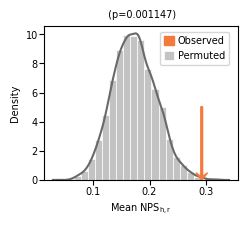

In [61]:
plot_permutation_histogram2(permuted_BMI, observed_BMI,'', 'Mean $NPS_{h,r}$',color="dimgrey", arrow_color="#F5793A")
plt.savefig(FIGDIR + "scaled_bmi_mean_nps.png", dpi=600, bbox_inches="tight",
           transparent=True)

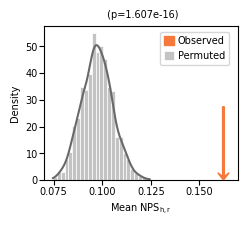

In [62]:
plot_permutation_histogram2(permuted_height, observed_height,'', 'Mean $NPS_{h,r}$',color="dimgrey", arrow_color="#F5793A")
plt.savefig(FIGDIR + "scaled_height_mean_nps_histogram.png", dpi=600, bbox_inches="tight",
           transparent=True)

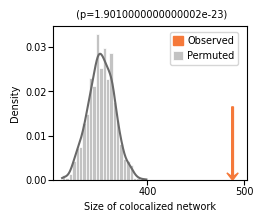

In [63]:
plot_permutation_histogram2(permuted_height_sz, observed_height_sz,'', 'Size of colocalized network',color="dimgrey", arrow_color="#F5793A")
plt.savefig(FIGDIR + "scaled_height_size_histogram.png", dpi=600, bbox_inches="tight",
           transparent=True)